<h1>Introduction</h1>
<p>Production of a Naïve Bayes spam filter</p> 
    
<p>The messages within the datasets have already been classified as ham (not spam), or spam. </p> 
<ul>
    <li>Data Set 1 consists of 5572 messages</li> 
    <li>Data Set 2 consists of 5728 messages</li>  
</ul>
    
<p>We primarily use data set one.</p>

<p>We avoid libraries such as scikit-learn in order to produce each component of the implementation ourselves.</p> 
<p>Bayes Theorem can give us the probability that a message is spam S for a given event E</p>

<h1>
$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$
</h1>

<p>Where:</p>
<p>$P\left(S\middle|\ E\right)$, the probability that the message is spam given the event occurred.</p>
<p>$P\left(S\right)$, the prior probability that a message is spam.</p>
<p>$P\left(\lnot S\right)$, the prior probability that a message is not spam.  </p>

<p>$P\left(E\middle|\ S\right)$, the probability that event E occurs in a spam email.</p>

<p>$P\left(E|\lnot S\right)$, the probability that event E occurs in non-spam email.</p>


<h3>1.  Data Reading

In [1]:
import pandas as pd
df = pd.read_csv("spam(1).csv", encoding="latin-1")
df.head(20)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


<h3>2. Data Cleaning</h3>


In [2]:

clean = df
clean = clean.drop(["Unnamed: 4", "Unnamed: 3", "Unnamed: 2"],  axis=1)
clean = clean.rename(columns={"v1":"Category", "v2":"Message"})
alphas = "abcdefghijklmnopqrstuvwxyz "
clean["Message"] = clean["Message"].apply(lambda x : "".join([z.lower() for z in list(x) if z.lower() in alphas]))

clean

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the nd time we have tried contact u u...
5568,ham,will b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


<h3>3. Data Partition</h3>

In [3]:
train_data = clean.sample(frac=0.75)
test_data = clean.drop(train_data.index)
train_data

,Category,Message
5507,ham,i want to be inside you every night
1518,ham,shall i ask one thing if you dont mistake me
3221,ham,hi my love how goes that day fuck this morning...
589,ham,im in a meeting call me later at
931,ham,congratulations ore mo owo re wa enjoy it and ...
...,...,...
1942,ham,kkwhy cant you come here and search job
1515,ham,i wonder if youll get this text
3347,ham,sorry ill call later
4846,ham,i am in escape theatre now going to watch kav...


<h3>4. Creating a Word Frequency DataFrame</h3>

In [4]:
train_data_spam = train_data[train_data["Category"] == "spam"]
train_data_ham = train_data[train_data["Category"] == "ham"]

spam_count = train_data_spam['Message'].str.split(expand=True).stack().value_counts()
ham_count = train_data_ham['Message'].str.split(expand=True).stack().value_counts()
word_freq = pd.DataFrame(pd.concat([spam_count, ham_count], axis=1, sort=False))

word_freq = word_freq.rename(columns={0:"#Spam", 1:"#Ham"})
word_freq = word_freq.fillna(0)
word_freq = word_freq.reset_index()
word_freq = word_freq.rename(columns={"index": "Word"})
word_freq

,Word,#Spam,#Ham
0,to,494.0,1192.0
1,a,267.0,773.0
2,call,264.0,165.0
3,you,206.0,1340.0
4,your,193.0,321.0
...,...,...,...
7235,gudk,0.0,1.0
7236,exterminator,0.0,1.0
7237,raping,0.0,1.0
7238,coping,0.0,1.0


<h3>5. Data Visualisation</h3>


In [5]:
#! pip install --user wordcloud # May be a circumstance needing to pip install again, here's the shell command commented out

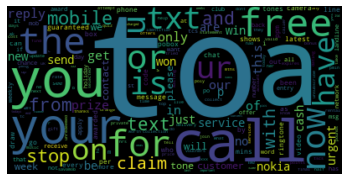

In [11]:
spamFrame = pd.DataFrame(spam_count)
spamFrame = spamFrame.rename(columns={0:"#Spam", 1:"#Ham"})
spamFrame = spamFrame.fillna(0)
spamFrame = spamFrame.reset_index()
spamFrame = spamFrame.rename(columns={"index": "Word"})

temp_d = {}
for k, v in spamFrame.values:
    temp_d[k] = v

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=temp_d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3>6.  Calculating $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$</h3>
<p>Next create a new DataFrame named word_prob that gives the probability of each word being found in a spam and ham message.</p>
<p>If a word was not found in ham or spam it will cause problems later because the probability calculated will be zero. Therefore, use a pseudocount k and estimate the probability of seeing the word. This is known as smoothing..</p>


In [7]:
k = 0.5
e_given_s = spam_count.apply(lambda x : (x + k)/(spam_count.sum() + 2 * k))

e_given_not_s = ham_count.apply(lambda x : (x + k)/(ham_count.sum() + 2 * k))

word_prob = pd.DataFrame(pd.concat([e_given_s, e_given_not_s], axis=1, sort=False))

word_prob = word_prob.rename(columns={0:"P(E|S)", 1:"P(E|¬S)"})
word_prob = word_prob.fillna(0)
word_prob["P(E|S)"] = word_prob["P(E|S)"].apply(lambda x : (x + k)/(spam_count.sum() + 2 * k) if x == 0 else x)
word_prob["P(E|¬S)"] = word_prob["P(E|¬S)"].apply(lambda x : (x + k)/(ham_count.sum() + 2 * k) if x == 0 else x)
word_prob = word_prob.reset_index()
word_prob = word_prob.rename(columns={"index": "Word"})
word_prob

,Word,P(E|S),P(E|¬S)
0,to,0.043188,0.024022
1,a,0.023362,0.015582
2,call,0.023100,0.003334
3,you,0.018035,0.027003
4,your,0.016900,0.006476
...,...,...,...
7235,gudk,0.000044,0.000030
7236,exterminator,0.000044,0.000030
7237,raping,0.000044,0.000030
7238,coping,0.000044,0.000030


<h3>7. Checking the 'spamliness' of a single word</h3>
<p>Now that we have trained the model, we will test the model.  Before we use the test_data, first let’s check how the model calculates the spamliness of a single word.  This is where we use the Bayes Theorem formula.  We have already calculated $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$, so we can just extract these values from the word_prob DataFrame.</p>
<p>We need to decide on the prior values $P\left(S\right)$ and $P\left(\lnot S\right)$.</p>

In [8]:
p_s = 0.4
p_not_s = 1-p_s
def calc_prob(word):
    p_e_s = float(word_prob[word_prob["Word"] == word]["P(E|S)"])
    p_not_e_s = float(word_prob[word_prob["Word"] == word]["P(E|¬S)"])
    
    print("Word: " + str(word))
    print("P(E|S) = " + str(p_e_s))
    print("P(E|¬S) = " + str(p_not_e_s))
    print("P(S|E) = " + str(p_e_s*p_s/(p_e_s*p_s + p_not_e_s*p_not_s)))
    print("P(¬S|E) = " + str(p_not_e_s*p_not_s/(p_e_s*p_s + p_not_e_s*p_not_s)))

calc_prob("free")

Word: free
P(E|S) = 0.014890829694323144
P(E|¬S) = 0.000997139518955723
P(S|E) = 0.9087232953267154
P(¬S|E) = 0.09127670467328461


<h3>8. Checking the 'spamliness' of several words</h3>
<p>To check the spamliness of several words contained in a message we multiply the probabilities.  The model assumes the words appear as independent events hence the naïve Bayes.  In reality of course, words are not independent events, but the model still performs well.  So we use the assumption that the words appear independently, and hence we multiply probabilities.</p>

In [9]:
def message_spamliness(message):
    p_s = 0.4
    p_not_s = 1 - p_s
    product_s = 1
    product_not_s = 1
    message_list = message.split()
    for word in message_list:
        if len(word_prob[word_prob["Word"] == word]["P(E|S)"]) != 0:
            product_s = float(product_s * word_prob[word_prob["Word"] == word]["P(E|S)"])
        if len(word_prob[word_prob["Word"] == word]["P(E|¬S)"]) != 0:
            product_not_s = float(product_not_s * word_prob[word_prob["Word"] == word]["P(E|¬S)"])

    spam_prob = product_s*p_s/(product_s*p_s + product_not_s*p_not_s)
    not_spam_prob = product_not_s*p_not_s/(product_s*p_s + product_not_s*p_not_s)
    if spam_prob > not_spam_prob:
        print("spam")
    else:
        print("ham")

#message_spamliness("i love lamp")

<h3>9. Avoiding floating point underflow</h3>

<p> To avoid multiplication of small numbers, we use the following property of $\log(x):$</p>
$$
\log(a\cdot b)=\log(a)+\log(b)
$$
<p>i.e. the log of the product is equal to the sum of logs (so instead of multiplying small numbers we will add them).</p>


In [10]:
import numpy as np
def message_spamliness_logs(message):
    p_s = 0.4
    p_not_s = 1 - p_s
    product_s = np.log(p_s)
    product_not_s = np.log(p_not_s)
    message_list = message.split()
    for word in message_list:
        if len(word_prob[word_prob["Word"] == word]["P(E|S)"]) != 0:
            product_s = float(product_s + np.log(word_prob[word_prob["Word"] == word]["P(E|S)"]))
        if len(word_prob[word_prob["Word"] == word]["P(E|¬S)"]) != 0:
            product_not_s = float(product_not_s + np.log(word_prob[word_prob["Word"] == word]["P(E|¬S)"]))

    spam_prob = product_s
    not_spam_prob = product_not_s
    
    if spam_prob > not_spam_prob:
        #print("spam")
        return("spam")
    else:
        #print("ham")
        return("ham")

#message_spamliness_logs("")

<h3>10. Model Testing</h3>


In [11]:
#print(test_data.head(20))
match_spam = 0
match_ham = 0
thought_ham_is_spam = 0
thought_spam_is_ham = 0
for x in test_data["Message"].values:
    actual_class = test_data[test_data["Message"] == x]["Category"].values[0]
    predicted_class = message_spamliness_logs(x)
    if predicted_class == "ham" and predicted_class == actual_class:
        match_ham += 1
    elif predicted_class == "ham" and predicted_class != actual_class:
        thought_spam_is_ham += 1
    elif predicted_class == "spam" and predicted_class == actual_class:
        match_spam += 1
    else:
        thought_ham_is_spam += 1
        
print("match_spam: " + str(match_spam))
print("match_ham: " + str(match_ham))
print("thought_ham_is_spam: " + str(thought_ham_is_spam))
print("thought_spam_is_ham: " + str(thought_spam_is_ham))
print("Accuracy: " + str( (match_spam+match_ham)/(match_spam+match_ham+thought_ham_is_spam+thought_spam_is_ham) ))

match_spam: 186
match_ham: 1151
thought_ham_is_spam: 44
thought_spam_is_ham: 12
Accuracy: 0.9597989949748744


<h3>11. Improvements</h3>

<h5> The given data set contains far more examples of ham messages than spam ones. This could be alleviated by generally collecting more emails, focused on spam emails. Furthermore, our prior of 0.4 for P(S) is not accurately represented according to our data, so our prior could be selected according to real world statistics on spam emails. This could also be applied to our pseudocount value 'k'. </h5>

<h5> Of course, our Bayes classifier is naive and unable to classify messages consisting of purely unseen words, so a better learning model may account for unseen words. Finally, the data set source is unknown, it may be possible that repositories now exist better suited for a classifier model and the data cleaning process could have accounted for how punctuation marks up spam/ham emails. </h5>

<h3></h3>